# [Neural Style Transfer (Gatys et al.)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using  [Swift for TensorFlow](https://github.com/tensorflow/swift)

## What _is_ Neural Style Transfer?

Simply put, Style Transfer is a process by which we take the _style_ of one image, the _content_ of another image and generate a new image that exhibits the same stylistic features as the style image whilst preserving the high-level structure of the content image.

The neural part, as you might expect, is where the real magic happens. If you've read about or taken a course on Convolutional Neural Networks, you've probably encountered the wonderful paper [Visualizing and Understanding Convolutional Networks](http://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Zeiler and Fergus. This paper keenly illustrates the fact that each kernel in a conv net acts as a sort of feature extractor. The features start out primitive and local but as the net goes deeper, the features become more abstract and global. Neural Style Transfer exploits this fact, extracting style information from the activations of various layers. We also extract _content_ information from the higher layers of the network. We use this information to compute what is referred to in the literature as the "Perceptual Loss".

Given an input image, our goal is to minimize Perceptual Loss with respect to that image. In order to compute the Perceptual Loss, we need the following:
* A style image
* A content image
* A styled image. This is the output. We can initialize it a number of ways (which we'll explore below).
* A way of extracting style information from layer activations. 
* A pretrained conv net.

<img src="StyleGraphic.jpg">

Attribution from left to right:

* King of Hearts / Wikimedia Commons / CC-BY-SA-3.0 [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)]
* A Starry Night by Vincent van Gogh, c. June 1889
* Image generated by employing the Neural Style Transfer algorithm [detailed by Gatys et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

## Let's get started

You'll need the latest Swift for TensorFlow toolchain. See https://github.com/tensorflow/swift

In [1]:
import TensorFlow
import Python

In [2]:
// A utility for loading VGG-19 weights from a checkpoint file. 
%include "CheckpointReader.swift"

## Create a gram matrix utility on `Tensor`

In [3]:
public extension Tensor where Scalar: TensorFlowFloatingPoint {

    // Define the gram product.
    @differentiable
    func gramMatrix() -> Tensor<Scalar> {
        
        // Reshape to flatten the image dims to one dimension. Drop the batch dimension as well.
        let flatActivation = reshaped(to: TensorShape(shape[0], 
                                      shape[1] * shape[2], 
                                      shape[3])).squeezingShape(at: 0)
        
        // Take the matrix product of the transpose by the original. 
        return (flatActivation.transposed() • flatActivation) / Scalar(shape[1] * shape[2]) 
    }
}


## Define a layer for the input image

**Note:** This is probably not the best way to handle this, but after trying a few alternatives, I landed on this. The idea is that we want to freeze the parameters of the Conv Net and only update the input image during back prop. At the time of writing this, I couldn't find a straightforward way to **A)** freeze a layer while still computing gradients and **B)** have the input image be a tunable parameter. I have some ideas on how I might be able to better handle this, but this works well enough for now. 

In [4]:
// This layer allows us to update the input image during back propagation. 
// Probably not ideal. See above fore more info.
struct ImageTensorLayer: Layer {
    
    // This is the actual image that we'll be passing through the network.
    var imageTensor: Tensor<Float>
    
    init(imageTensor: Tensor<Float>) {
        self.imageTensor = imageTensor
    }
    
    // Note that this call ignores the input parameter and just passes imageTensor through.
    @differentiable
    func call(_ input: Tensor<Float>) -> Tensor<Float> {
        return self.imageTensor
    }
}

## Define a struct to store the output activations

At the time of writing this, arrays weren't differentiable. Swift for TensorFlow also doesn't currently support differentiable control flow which leads to more repititious code. It also doesn't support pulling activations out of a net after a forward pass. There are definitely work arounds for both of these issues but they involve writing a decent amount of code which would distract from the task at hand. At some point this functionality will probably be baked into the S4TF deep learning framework.

In [5]:
// This is used to store the output activations. These are used to compute the perceptual loss.
// As the property names suggest, we'll be using layers 1a, 2a, 3a, 4a and 5a for our style loss.
// and layers 4b and 5b for our content loss. 

struct OutputActivations: Differentiable {
    var activation1a: Tensor<Float>
    var style1a:      Tensor<Float>
    var activation2a: Tensor<Float>
    var style2a:      Tensor<Float>
    var activation3a: Tensor<Float>
    var style3a:      Tensor<Float>
    var activation4a: Tensor<Float>
    var style4a:      Tensor<Float>
    var activation4b: Tensor<Float>
    var activation5a: Tensor<Float>
    var style5a:      Tensor<Float>
    var activation5b: Tensor<Float>

    @differentiable
    init(activation1a: Tensor<Float>,
         activation2a: Tensor<Float>,
         activation3a: Tensor<Float>,
         activation4a: Tensor<Float>,
         activation4b: Tensor<Float>,
         activation5a: Tensor<Float>,
         activation5b: Tensor<Float>) {
        
        self.activation1a = activation1a
        self.style1a = activation1a.gramMatrix()
        
        self.activation2a = activation2a
        self.style2a = activation2a.gramMatrix()
        
        self.activation3a = activation3a
        self.style3a = activation3a.gramMatrix()
        
        self.activation4a = activation4a
        self.style4a = activation4a.gramMatrix()
        
        self.activation4b = activation4b
        
        self.activation5a = activation5a
        self.style5a = activation5a.gramMatrix()
        
        self.activation5b = activation5b
    }
}

## Define a concrete pooling type that we can swap on the fly

Again, once differentiable control flow lands, this sort of thing shouldn't be necessary. I tried getting this to work nicely with generics but to no avail. I looked to the way activation functions were implemented to achieve this.

In [6]:
enum PoolingType{
    case max
    case avg
}

struct PoolingLayer<Scalar: TensorFlowFloatingPoint>: Layer {    
    
    public typealias PoolingOperation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    @noDerivative let poolingOperation: PoolingOperation

    init(poolingType: PoolingType, 
         poolSize: (Int, Int), 
         strides: (Int, Int), 
         padding: Padding = .valid) {
        
        switch poolingType {
            case .max:
                let maxPool = MaxPool2D<Scalar>(poolSize: poolSize, strides: strides, padding: padding)
                poolingOperation = { (input: Tensor<Scalar>) -> Tensor<Scalar> in 
                                        return maxPool(input)
                                   }
            case .avg:
                let avgPool = AvgPool2D<Scalar>(poolSize: poolSize, strides: strides, padding: padding)
                poolingOperation = { (input: Tensor<Scalar>) -> Tensor<Scalar> in 
                                        return avgPool(input)
                                   }
        }
    }
    
    
    @differentiable
    func call(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return poolingOperation(input)
    }
}

## Implement VGG19 architecture without classification head

In [7]:
struct VGG19: Layer {
    var conv1a: Conv2D<Float>
    var conv1b: Conv2D<Float>
    
    var conv2a: Conv2D<Float>
    var conv2b: Conv2D<Float>
    
    var conv3a: Conv2D<Float>
    var conv3b: Conv2D<Float>
    var conv3c: Conv2D<Float>
    var conv3d: Conv2D<Float>
    
    var conv4a: Conv2D<Float>
    var conv4b: Conv2D<Float>
    var conv4c: Conv2D<Float>
    var conv4d: Conv2D<Float>
    
    var conv5a: Conv2D<Float>
    var conv5b: Conv2D<Float>
    var conv5c: Conv2D<Float>
    var conv5d: Conv2D<Float>
    
    // Default to max pooling
    var poolingLayer = PoolingLayer<Float>(poolingType: .max, 
                                           poolSize: (2, 2), 
                                           strides: (2, 2))
    
    init() {
        // CheckpointReader defines an extension that reads the weights and biases for a given conv layer.
        // I just threw CheckpointReader together for this notebook so it's not super reusable, but proper
        // model saving/loading/checkpointing is on the roadmap so it'll be easier to swap to that once it's
        // available.
        
        // Layer 1        
        self.conv1a = Conv2D(named: "block1_conv1")
        self.conv1b = Conv2D(named: "block1_conv2")
        
        // Layer 2
        self.conv2a = Conv2D(named: "block2_conv1")
        self.conv2b = Conv2D(named: "block2_conv2")
        
        // Layer 3
        self.conv3a = Conv2D(named: "block3_conv1")
        self.conv3b = Conv2D(named: "block3_conv2")
        self.conv3c = Conv2D(named: "block3_conv3")
        self.conv3d = Conv2D(named: "block3_conv4")
        
        // Layer 4
        self.conv4a = Conv2D(named: "block4_conv1")
        self.conv4b = Conv2D(named: "block4_conv2")
        self.conv4c = Conv2D(named: "block4_conv3")
        self.conv4d = Conv2D(named: "block4_conv4")
        
        // Layer 5
        self.conv5a = Conv2D(named: "block5_conv1")
        self.conv5b = Conv2D(named: "block5_conv2")
        self.conv5c = Conv2D(named: "block5_conv3")
        self.conv5d = Conv2D(named: "block5_conv4")
    }
    
    @differentiable
    func call(_ input: Tensor<Float>) -> OutputActivations {
        var tmp = input
        
        // Layer 1
        tmp = conv1a(tmp)
        let act1a = tmp
        tmp = conv1b(tmp)
        tmp = poolingLayer(tmp)
        
        // Layer 2 
        tmp = conv2a(tmp)
        let act2a = tmp
        tmp = conv2b(tmp)
        tmp = poolingLayer(tmp)
        
        // Layer 3
        tmp = conv3a(tmp)
        let act3a = tmp
        tmp = conv3b(tmp)
        tmp = conv3c(tmp)
        tmp = conv3d(tmp)
        tmp = poolingLayer(tmp)
        
        // Layer 4
        tmp = conv4a(tmp)
        let act4a = tmp
        tmp = conv4b(tmp)
        let act4b = tmp
        tmp = conv4c(tmp)
        tmp = conv4d(tmp)
        tmp = poolingLayer( tmp)
        
        // Layer 5
        tmp = conv5a(tmp)
        let act5a = tmp
        tmp = conv5b(tmp)
        let act5b = tmp
        tmp = conv5c(tmp)
        tmp = conv5d(tmp)
        tmp = poolingLayer(tmp)
        
        return OutputActivations(activation1a: act1a, 
                                 activation2a: act2a, 
                                 activation3a: act3a, 
                                 activation4a: act4a, 
                                 activation4b: act4b, 
                                 activation5a: act5a,
                                 activation5b: act5b)
    }
}

In [8]:
struct LossNet: Layer {
    var inputLayer: ImageTensorLayer
    var model: VGG19
    
    init(inputLayer: ImageTensorLayer, model: VGG19) {
        self.inputLayer = inputLayer
        self.model = model
    }
    
    @differentiable
    func call(_ input: Tensor<Float>) -> OutputActivations {
        let image = self.inputLayer(input)
        return model(image)
    }
}

## Instantiate the VGG19 model to make sure everything is working

In [9]:
var baseModel = VGG19()

In [11]:
func zeroTensor(tensor: Tensor<Float>) -> Tensor<Float> {
    return Tensor<Float>(zeros: tensor.shape)
}

/// Adam optimizer.
///
/// Reference: ["Adam - A Method for Stochastic Optimization"](
/// https://arxiv.org/abs/1412.6980v8)
public class ImageAdam<Model: Layer>: Optimizer
    where Model.AllDifferentiableVariables == Model.CotangentVector {
    /// The learning rate.
    public var learningRate: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta1: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta2: Float
    /// A small scalar added to the denominator to improve numerical stability.
    public var epsilon: Float
    /// The weight decay.
    public var decay: Float
    /// The current step.
    public var step: Int = 0
    /// The first moments of the weights.
    public var firstMoments: Model.AllDifferentiableVariables
    /// The second moments of the weights.
    public var secondMoments: Model.AllDifferentiableVariables

    public init(
        for model: __shared Model,
        learningRate: Float = 1e-3,
        beta1: Float = 0.9,
        beta2: Float = 0.999,
        epsilon: Float = 1e-8,
        decay: Float = 0
    ) {
        precondition(learningRate >= 0, "Learning rate must be non-negative")
        precondition(0 <= beta1 && beta1 <= 1, "Beta parameter must be between 0 and 1")
        precondition(0 <= beta2 && beta2 <= 1, "Beta parameter must be between 0 and 1")
        precondition(decay >= 0, "Weight decay must be non-negative")

        self.learningRate = learningRate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.decay = decay

        // Initialize first & second moments to be zeros of the same shape.
        // We can't use `Model.AllDifferentiableVariables.zero` due to the
        // interaction between Key Paths and Differentiable Arrays.
        firstMoments = model.allDifferentiableVariables
        secondMoments = model.allDifferentiableVariables
        for kp in firstMoments.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] = zeroTensor(tensor: firstMoments[keyPath: kp])
            secondMoments[keyPath: kp] = zeroTensor(tensor: secondMoments[keyPath: kp])
        }
    }


    public func update(_ model: inout Model.AllDifferentiableVariables,
                       along direction: Model.AllDifferentiableVariables) {
        step += 1
        let learningRate = self.learningRate * 1 / (1 + decay * Float(step))
        let stepSize = learningRate * (sqrt(1 - pow(beta2, Float(step))) /
            (1 - pow(beta1, Float(step))))
        
        // Update Float Tensor variables.
        for kp in model.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] =
                firstMoments[keyPath: kp] * beta1 + (1 - beta1) * direction[keyPath: kp]
            secondMoments[keyPath: kp] =
                secondMoments[keyPath: kp] * beta2 + (1 - beta2) *
                direction[keyPath: kp] * direction[keyPath: kp]
            model[keyPath: kp] -=
                stepSize * firstMoments[keyPath: kp] / (sqrt(secondMoments[keyPath: kp]) + epsilon)
            break
        }
    }
}

In [12]:
@differentiable
public func MSELoss<Scalar: TensorFlowFloatingPoint>(
predicted: Tensor<Scalar>, expected: Tensor<Scalar>
) -> Tensor<Scalar> {
    
    return (expected - predicted).squared().mean()
}

In [13]:
@differentiable
public func totalVariationLoss(imageTensor: Tensor<Float>) -> Tensor<Float> { 
    
    let rank = imageTensor.rank
    let shape = imageTensor.shape
        
    let diff1LowerUp = [0, 1, 0, 0]
    let diff1UpperUp = [1, shape[1], shape[2], shape[3]]
    
    let diff1LowerDown = [0, 0, 0, 0]
    let diff1UpperDown = [1, shape[1] - 1, shape[2], shape[3]]
    
    let diff2LowerUp = [0, 0, 1, 0]
    let diff2UpperUp = [1, shape[1], shape[2], shape[3]]
    
    let diff2LowerDown = [0, 0, 0, 0]
    let diff2UpperDown = [1, shape[1], shape[2] - 1, shape[3]]
    
    let pixelDiff1 = imageTensor.slice(lowerBounds: diff1LowerUp, upperBounds: diff1UpperUp)
                     - imageTensor.slice(lowerBounds: diff1LowerDown, upperBounds: diff1UpperDown)
    
    let pixelDiff2 = imageTensor.slice(lowerBounds: diff2LowerUp, upperBounds: diff2UpperUp)
                     - imageTensor.slice(lowerBounds: diff2LowerDown, upperBounds: diff2UpperDown)
    
    return (pixelDiff1 * pixelDiff1).mean() + (pixelDiff2 * pixelDiff2).mean()
}

In [14]:
@differentiable
func perceptualLoss(contentActivations: OutputActivations, 
                      styleActivations: OutputActivations,
                     targetActivations: OutputActivations,
                         contentWeight: Float,
                          styleWeights: [Float]) -> Tensor<Float> {
    
    var loss = MSELoss(predicted: targetActivations.activation4b, 
                        expected: contentActivations.activation4b) * contentWeight
    
    loss = loss + MSELoss(predicted: targetActivations.activation5b, 
                          expected: contentActivations.activation5b) * contentWeight
    
    loss = loss + MSELoss(predicted: targetActivations.style1a, 
                           expected: styleActivations.style1a) * (styleWeights[0])
    
    loss = loss + MSELoss(predicted: targetActivations.style2a, 
                           expected: styleActivations.style2a) * (styleWeights[1])
    
    loss = loss + MSELoss(predicted: targetActivations.style3a, 
                           expected: styleActivations.style3a) * (styleWeights[2])
    
    loss = loss + MSELoss(predicted: targetActivations.style4a, 
                           expected: styleActivations.style4a) * (styleWeights[3] )
    
    loss = loss + MSELoss(predicted: targetActivations.style5a, 
                           expected: styleActivations.style5a) * (styleWeights[4])
    
    return loss
}

In [15]:
func clamp(image: Tensor<Float>, to mean: Tensor<Float>) -> Tensor<Float> {
    let maxTensor = mean.broadcast(like: image)
    let minTensor = -maxTensor
    
    let clampedImage = max(min(image, maxTensor), minTensor)
    
    return clampedImage
}

## Use Python interoperability to show images via matplotlib

In [16]:
let np = Python.import("numpy")
let display = Python.import("IPython.display")

In [17]:
func loadImage(fileName: StringTensor) -> Tensor<UInt8> {
    let imageBytes: StringTensor = Raw.readFile(filename: fileName)
    return Raw.decodeJpeg(contents: imageBytes, dctMethod: "")
}

In [18]:
func centerCrop<Scalar: TensorFlowNumeric>(image: Tensor<Scalar>, size: Int32) -> Tensor<Float> {
    let rank = image.rank
    precondition(rank == 4, "Image must be of rank 4 but image is of rank \(rank).")
    let (height, width) = (Float(image.shape[rank - 3]), Float(image.shape[rank - 2]))
    
    precondition(width * height > Float(size * size), 
                 "Image of size: (\(height), \(width)) already smaller than \(size).")
    
    let verticalSpace: Float = (height - Float(size)) / Float(2.0)
    let horizontalSpace: Float = (width - Float(size)) / Float(2.0)
    
    let y2 = (height - verticalSpace) / Float(height - 1.0)
    let x2 = (width - horizontalSpace) / Float(width - 1.0)
    let y1 = verticalSpace / Float(height - 1.0)
    let x1 = horizontalSpace / Float(width - 1.0)
        
    let boxes = Tensor<Float>([y1, x1, y2, x2]).expandingShape(at: 0)
    let cropSize = Tensor<Int32>([size, size])
    
    return Raw.cropAndResize(image: image, 
                             boxes: boxes, 
                             boxInd: [0], 
                             cropSize: cropSize)    
}

In [19]:
enum ByteOrdering {
    case bgr
    case rgb
}

In [28]:
func preprocess(image: Tensor<UInt8>,
                size: Int32,
                inByteOrdering: ByteOrdering,
                outByteOrdering: ByteOrdering,
                meanToSubtract: Tensor<Float>) -> Tensor<Float> {
    
    let rank = image.rank
    let (height, width) = (Float(image.shape[rank - 3]), Float(image.shape[rank - 2]))
    
    var resizedImage = Tensor<Float>(image.expandingShape(at: 0))
    
    if width * height > Float(size * size) {
        resizedImage = centerCrop(image: resizedImage, size: size)
    } else {
        let sizeTensor = Tensor<Int32>([size, size])
        var resizedImage = Tensor<Float>(Raw.resizeNearestNeighbor(images: resizedImage, 
                                                                   size: sizeTensor))        
    }
        
    if inByteOrdering != outByteOrdering {
        resizedImage = Raw.reverse(resizedImage, dims: Tensor<Bool>([false, false, false, true]))
    }
    
    return resizedImage - meanToSubtract.expandingShape(at: 0)
}

func postprocess(image: Tensor<Float>,
                 inByteOrdering: ByteOrdering,
                 outByteOrdering: ByteOrdering, 
                 meanToAdd: Tensor<Float>) -> Tensor<UInt8> {

    // Raw.reverse(meanToAdd, dims: Tensor<Bool>([true]))
    var processedImage = image + meanToAdd
    
    if inByteOrdering != outByteOrdering {
        processedImage = Raw.reverse(processedImage, dims: Tensor<Bool>([false, false, false, true]))
    }

    return Tensor<UInt8>(processedImage).squeezingShape(at: 0)
}

In [29]:
// Setup.
%include "EnableIPythonDisplay.swift"
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [30]:
let imageNetMean = Tensor<Float>([116.779, 103.939, 123.68])

In [31]:
struct StyleTransferResult: CustomStringConvertible {
    var outputImages: [Tensor<Float>] = []
    
    let styleWeights: [Float]
    let contentWeight: Float
    let lr: Float
    let iterations: Int
    let saveEvery: Int
    
    var description: String {
        let description = """
               contentWeight: \(contentWeight)\n 
               styleWeights: \(styleWeights)\n
               lr: \(lr)\n
               iterations: \(iterations)\n
               saveEvery: \(saveEvery)\n
               """
        return description
    }
    
    init(styleWeights: [Float], 
         contentWeight: Float, 
         lr: Float, 
         iterations: Int,
         saveEvery: Int) {
        self.styleWeights = styleWeights
        self.contentWeight = contentWeight
        self.lr = lr
        self.iterations = iterations
        self.saveEvery = saveEvery
    }
    
    public func showImages() {
        let (rows, cols) = (Int(ceil(Float(outputImages.count) / Float(3.0))), 3)
        
        plt.figure(figsize: [15, 15])
        for i in 0..<(rows * cols) {
            if i  > outputImages.count - 1 {
                break
            }
            
            let img = plt.subplot(rows, cols, i + 1)
            img.axis("off")
            let pixelTensor = postprocess(image: outputImages[i],
                                          inByteOrdering: .bgr,
                                          outByteOrdering: .rgb,
                                          meanToAdd: imageNetMean)
            
            let x = pixelTensor.makeNumpyArray()
            img.imshow(x)
            img.set_title("Iteration: \(i * saveEvery)")
        }
        
        plt.show()        
    }
}


In [32]:
let contentImageBytes = loadImage(fileName:StringTensor("./painted_ladies_256.jpg"))
let contentImageTensor = preprocess(image: contentImageBytes, 
                                    size: 256, 
                                    inByteOrdering: .rgb, 
                                    outByteOrdering: .bgr,
                                    meanToSubtract: imageNetMean)

// let styleImageBytes = loadImage(fileName:StringTensor("./vangogh_starry_night.jpg")).expandingShape(at: 0)
let styleImageBytes = loadImage(fileName:StringTensor("./vangogh_starry_night_256.jpg"))
let styleImageTensor = preprocess(image: styleImageBytes, 
                                  size: 256, 
                                  inByteOrdering: .rgb, 
                                  outByteOrdering: .bgr, 
                                  meanToSubtract: imageNetMean)

In [33]:
print(contentImageTensor.shape)
print(styleImageTensor.shape)

TensorShape(dimensions: [1, 256, 256, 3])
TensorShape(dimensions: [1, 256, 256, 3])


In [34]:
func showImageTensor(tensor: Tensor<Float>,
                     byteOrdering: ByteOrdering) {
    plt.figure(figsize: [5, 5])
    plt.axis("off")
    let pixelTensor = postprocess(image: tensor,
                                  inByteOrdering: byteOrdering, 
                                  outByteOrdering: .rgb, 
                                  meanToAdd: imageNetMean)
    plt.imshow(pixelTensor.makeNumpyArray())
    plt.show()
}

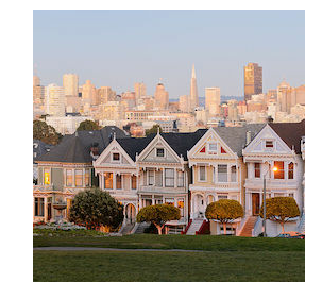

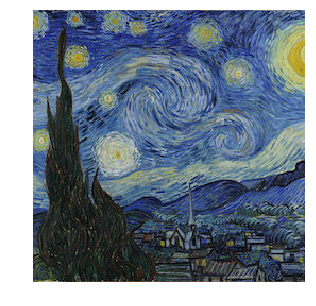

In [35]:
showImageTensor(tensor: contentImageTensor, byteOrdering: .bgr)
showImageTensor(tensor: styleImageTensor, byteOrdering: .bgr)

In [36]:
let contentInputLayer = ImageTensorLayer(imageTensor: contentImageTensor)
let styleInputLayer = ImageTensorLayer(imageTensor: styleImageTensor)

var contentLossNet = LossNet(inputLayer: contentInputLayer, model: baseModel)
var styleLossNet = LossNet(inputLayer: styleInputLayer, model: baseModel)

### Compute the activations for the style and content layers. 

In [37]:
// Compute the content activations
let contentActivations = contentLossNet.inferring(from: contentImageTensor)

// Compute the style activations
let styleActivations = styleLossNet.inferring(from: styleImageTensor)

In [38]:
func train(model: inout LossNet, 
              lr: Float, 
      iterations: Int = 450, 
   contentWeight: Float,
    styleWeights: [Float],
       saveEvery: Int) -> StyleTransferResult {
    let targetOptimizer = ImageAdam(for: model, learningRate: lr, beta1: 0.9, beta2: 0.999, epsilon: 1e-8)
    
    var result = StyleTransferResult(styleWeights: styleWeights, 
                                     contentWeight: contentWeight, 
                                     lr: lr, 
                                     iterations: iterations,
                                     saveEvery: saveEvery)
    
    for i in 0..<iterations {
        var lastLoss: Float = 0.0
        
        let 𝛁model = model.gradient { model -> Tensor<Float> in
            let targetActivations = model(model.inputLayer.imageTensor)
            var loss = perceptualLoss(contentActivations: contentActivations, 
                                        styleActivations: styleActivations, 
                                       targetActivations: targetActivations,
                                           contentWeight: contentWeight,
                                            styleWeights: styleWeights)

            lastLoss = loss.scalarized()
                                      
            return loss
        }
        
        targetOptimizer.update(&model.allDifferentiableVariables, along: 𝛁model)
        
        model.inputLayer.imageTensor = clamp(image: model.inputLayer.imageTensor, to: imageNetMean)
        if i % saveEvery == 0  {
            print("[Iteration \(i) - Perceptual Loss: \(lastLoss)]")
            result.outputImages.append(model.inputLayer.imageTensor)
        } else if i == iterations - 1 {
            print("[Iteration \(iterations) - Perceptual Loss: \(lastLoss)]")
            result.outputImages.append(model.inputLayer.imageTensor)
        }
    }
    
    return result
}

In [39]:
var results: [StyleTransferResult] = []

In [42]:
let styledImageTensor = preprocess(image: contentImageBytes, 
                                    size: 256, 
                                    inByteOrdering: .rgb, 
                                    outByteOrdering: .bgr,
                                    meanToSubtract: imageNetMean)

let styledInputLayer = ImageTensorLayer(imageTensor: styledImageTensor)

var targetLossNet = LossNet(inputLayer: styledInputLayer, model: baseModel)
let styleWeights: [Float] = [
Float(1e3 / Float(pow( 64.0 , 2.0))),
Float(1e3 / Float(pow( 128.0, 2.0))),
Float(1e3 / Float(pow( 256.0, 2.0))),
Float(1e3 / Float(pow( 512.0, 2.0))),
Float(1e3 / Float(pow( 512.0, 2.0)))]

let lr: Float = 4.0
let iterations = 500
let contentWeight:Float = 1.0

results.append(train(model: &targetLossNet, 
                        lr: lr, 
                iterations: iterations,
             contentWeight: contentWeight,
              styleWeights: styleWeights,
                 saveEvery: 100))

[Iteration 0 - Perceptual Loss: 5.745376e+08]
[Iteration 100 - Perceptual Loss: 5161447.0]
[Iteration 200 - Perceptual Loss: 3082735.0]
[Iteration 300 - Perceptual Loss: 2260038.8]
[Iteration 400 - Perceptual Loss: 1865742.6]
[Iteration 500 - Perceptual Loss: 1648403.2]


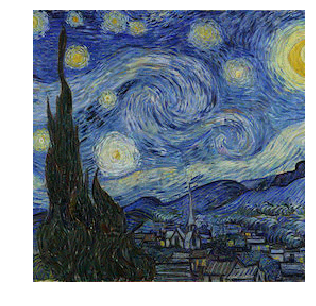

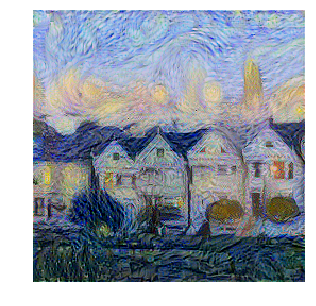

In [43]:
for result in results {
    showImageTensor(tensor: result.outputImages.last!, 
                    byteOrdering: .bgr)
}

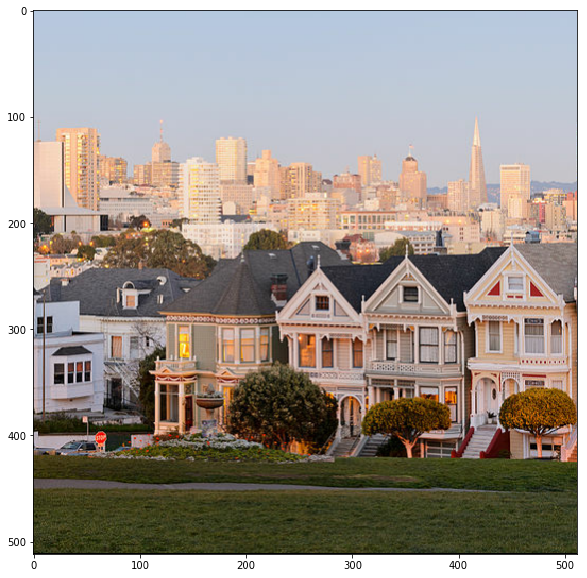

In [71]:
showImageTensor(tensor: contentImageTensor, byteOrdering: .bgr)

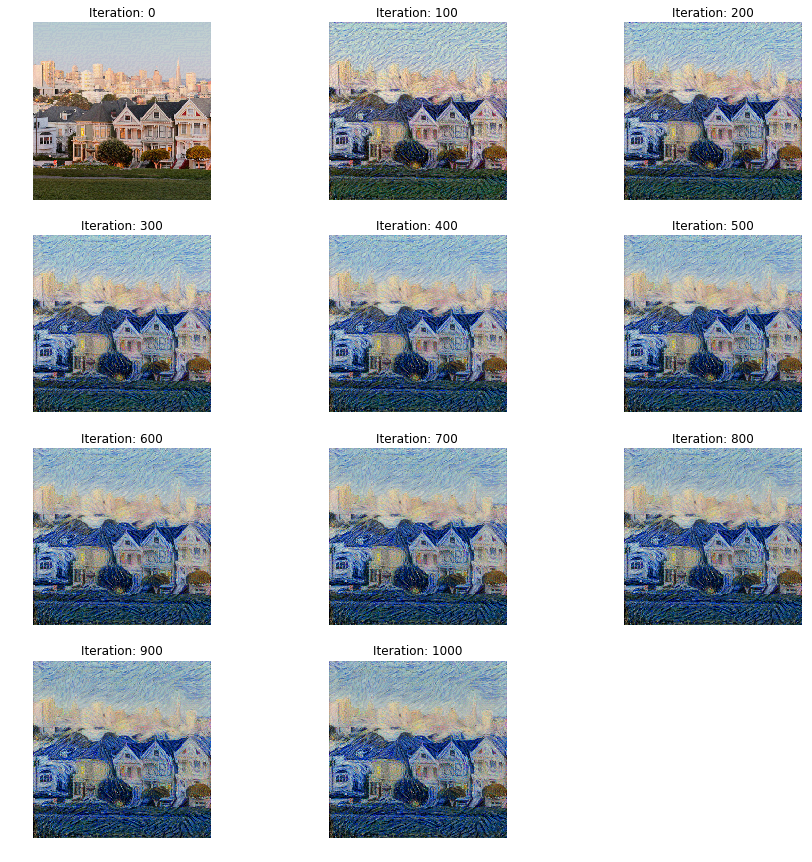

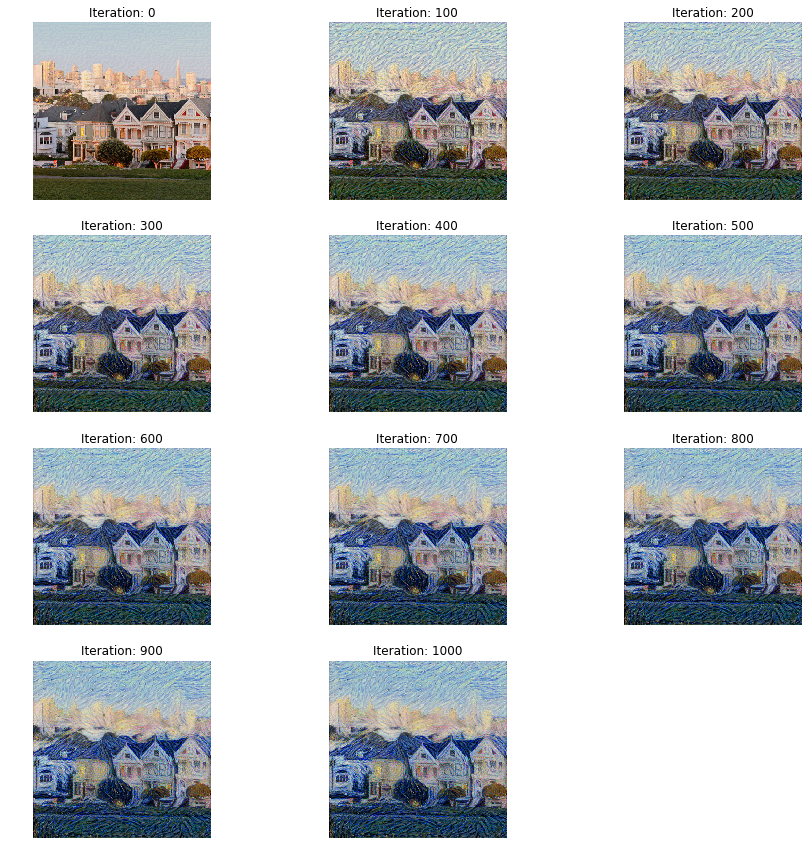

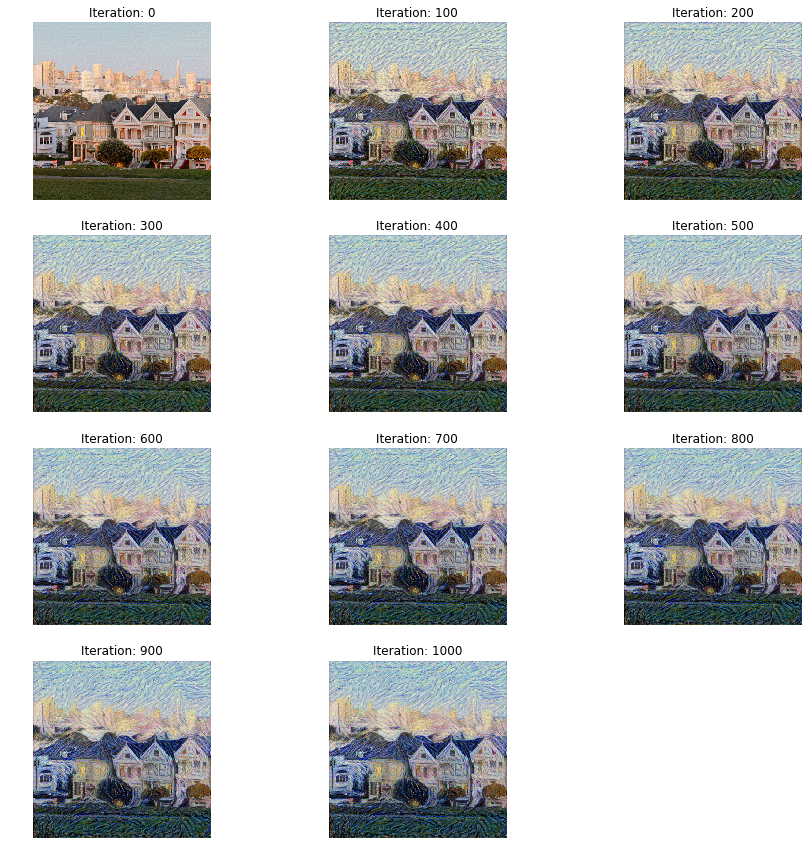

In [68]:
for result in results {
    result.showImages()
//     print(result.outputImages.last)
}

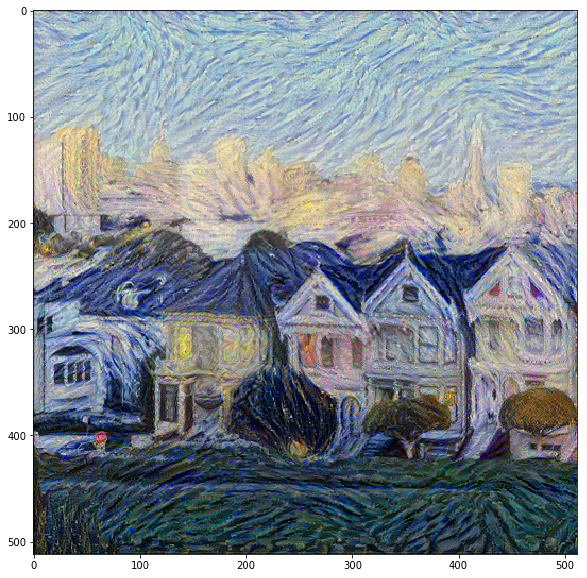

In [72]:
let result = results.last!.outputImages.last!
showImageTensor(tensor: result, byteOrdering: .bgr)

In [58]:
// let sobelX = Tensor<Float>([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
// let sobelXFilter = sobelX.reshaped(to: [1, 3, 3, 1]).broadcast(toShape: [1, 3, 3, 3])
// let sobelYFilter = sobelXFilter.transposed(withPermutations: [1, 0, 2, 3])
// print(sobelYFilter.shape)

let filterXY = highPassXY(imageTensor: result)

: 